## Independent Component Analysis
1. Center X by subtracting the mean
$$X - X.mean()$$
2. Whitening X
$$ E* D^{-1/2}* E^T *X $$
 - E Orthogonal matrix of eigenvector
 - D = $\lambda$ (matrix eigenvalues)
3. Choose a random inital  value for the de-mixing matrix W

4. Calculate the new value for W

5. Nomarlize W

6. check algorithm has converged, if it hasn't, return step 4

7. Take the dot product of W and X
$$ S = WX \\ \text{(Indenpent source signals )}$$


In [1]:
# Implementing FastICA from Scratch
#Implement libraries
# import torch
import numpy as np
from scipy import signal,linalg
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
# Set a seed for the random number generator for reproducibility
np.random.seed(23)

# Number of samples
ns = np.linspace(0, 200, 1000)

# Source matrix
S = np.array([np.sin(ns * 1),
              signal.sawtooth(ns * 1.9),
              np.random.random(len(ns))]).T

# Mixing matrix
A = np.array([[0.5, 1, 0.2],
              [1, 0.5, 0.4],
              [0.5, 0.8, 1]])

# Mixed signal matrix
X = S.dot(A).T

In [3]:
X.shape

(3, 1000)

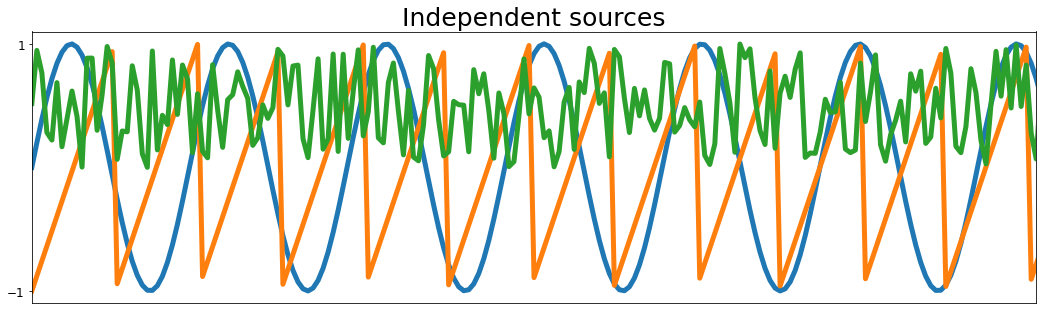

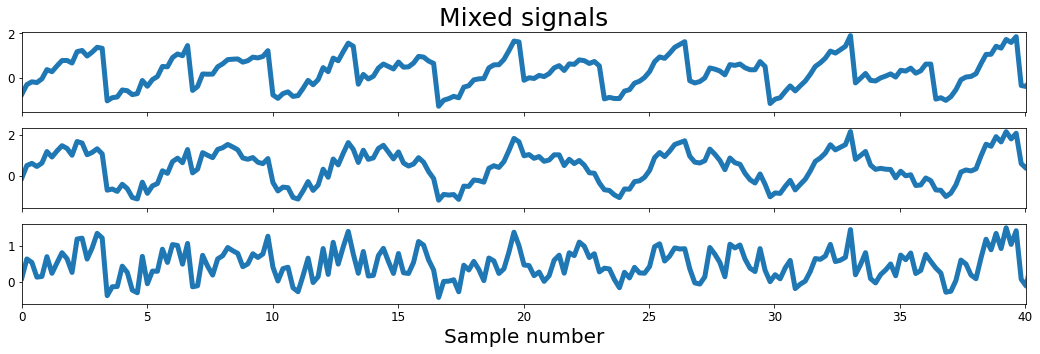

In [4]:
# Plot sources & signals
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(ns, S, lw=5)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_xlim(ns[0], ns[200])
ax.tick_params(labelsize=12)
ax.set_title('Independent sources', fontsize=25)

fig, ax = plt.subplots(3, 1, figsize=[18, 5], sharex=True)
ax[0].plot(ns, X[0], lw=5)
ax[0].set_title('Mixed signals', fontsize=25)
ax[0].tick_params(labelsize=12)

ax[1].plot(ns, X[1], lw=5)
ax[1].tick_params(labelsize=12)
ax[1].set_xlim(ns[0], ns[-1])

ax[2].plot(ns, X[2], lw=5)
ax[2].tick_params(labelsize=12)
ax[2].set_xlim(ns[0], ns[-1])
ax[2].set_xlabel('Sample number', fontsize=20)
ax[2].set_xlim(ns[0], ns[200])

plt.show()

In [5]:

# def covariance(x):
#     #Calculate covariance matrix
#     return np.cov(x)


#Preprocessing data

#Computing covariance matrix
def covariance(x):
    mean = np.mean(x, axis=1, keepdims=True)
    n = np.shape(x)[1] - 1
    m = x - mean

    return (m.dot(m.T))/n
#Centering
def centering(x):
    #Calculate mean vector
    mean = np.mean(x, axis=1, keepdims=True)
    # Centering the features of X
    centering =  x - mean
    return centering, mean

#Whitening
def whitening(x, n_components):
    # Calculate the covariance matrix
    covariance_matrix = covariance(x)
    
    # Single value decoposition
    E, S, V = linalg.svd(covariance_matrix, full_matrices=False, check_finite=False)
    del V
  
    # Calculate diagonal matrix of eigenvalues
    D = np.diag(1.0 / np.sqrt(S))

    # Calculate whitening matrix
    whitening_matrix = np.dot(E, np.dot(D, E.T))
    del E,S
    # Project onto whitening matrix
    whitening = np.dot(whitening_matrix, x)
#     whitening *= np.sqrt(x.shape[0])

    return whitening, whitening_matrix

#Preprocessing data
def preprocessing(x, n_components):
    if (not isinstance(x,np.ndarray)):
        x = x.to_numpy()
    x_centered,mean=centering(x)
    x_whitening, whitening_matrix=whitening(x_centered, n_components)
    return x_centered, mean, x_whitening, whitening_matrix

def _ica_weights(X, tol, max_iters, w_init):
    
    n_components = w_init.shape[0]
#     W = np.zeros((n_components, n_components), dtype=X.dtype)
    
    n_samples, n_features = X.shape
    # Initialize random weights
    W = np.random.rand(n_samples, n_samples)
    n_iter = []
    
    for component in range(n_components):
        # set W
#         w = w_init[component, :].copy()
        w = W[component, :].copy().reshape(n_samples, 1)

        # Normalize W
        w = w/np.sqrt((w**2).sum())

        # Num of iteration
        it=0

        # Gradient descent
        while (it < max_iters):
#             print('W shape',w.T.shape)
#             print('X shape',X.shape)
            # Calculate dot product of Weights and signals
            ws = np.dot(w.T, X)

            # Calculate tanh function
            wg = np.tanh(ws).T

            # Calculate derivative of tanh function
            wg_= (1-np.square(np.tanh(ws)))

            # Update weights
            wNew = (X*wg.T).mean(axis=1) - wg_.mean()*w.squeeze()
            
            
            # Decorrelate and normalize weights
            wNew = wNew-np.dot(np.dot(wNew, W[:component].T), W[:component])
            wNew = wNew/np.sqrt((wNew**2).sum())

            # Calculate limit condition
            lim=np.abs(np.abs((wNew*w).sum())-1)


            # Set new weights
            w = wNew

            # Check for convergence
            if (lim < tol):
                break

            it+=1

        n_iter.append(it + 1)
        #Set weight matrix
        W[component,:] = w.T

    return W, max(n_iter)

In [6]:
class FastICA_model:
    def __init__(self, n_components = None, w_init = None ,max_iters=500, random_state=None, tol=1e-8):
        self.n_components = n_components
        self.w_init = w_init
        self.max_iters = max_iters
        self.random_state = random_state
        self.tol = tol
        
        
    
    def fit_transform(self, X):
        n_samples, n_features = X.shape
        
        n_components = self.n_components
        if n_components is None :
            n_components = min(n_features, n_samples)
        
        
        
        X_center, mean, X_whiten, whiten_filter = preprocessing(X, n_components)
            
        self.mean_ = mean
        
        #Initialize random weights
        if self.w_init is None:
            random_state = np.random.RandomState(self.random_state)
            w_init = np.asarray(random_state.normal(size = (n_components, n_components)), X_whiten.dtype)
        else:
            w_init = np.asarray(self.w_init)
            if w_init.shape != (n_components, n_components):
                raise ValueError(
                    'w_init has invalid shape -- should be %(shape)s'
                    % {'shape': (n_components, n_components)})
                
        print('X_whiten ',X_whiten.shape)
        print('w_init ',w_init.shape)
        
        W, self.n_iter = _ica_weights(X_whiten, self.tol , self.max_iters, w_init)
        del X_whiten
        
        # project whitened data onto independent components:
        S = np.linalg.multi_dot([W, whiten_filter, X_center]).T
        
        # compute components
        self.component_ = np.dot(W, whiten_filter)
        
        # compute whitening matrix
        self.whitening_ = whiten_filter
        
        # compute unmixing matrix:
        self._unmixing = W
        
        # compute mixing matrix:
        self.mixing_ = linalg.pinv(self.component_, check_finite=False)

        
        return S
                   
            

X_whiten  (3, 1000)
w_init  (3, 3)
iter  6
[[-0.38969475  1.88536295 -1.39433177]
 [-1.78842559  0.0762338   4.2931061 ]
 [ 2.39655313 -1.15575162 -0.22146238]]
recovered  (1000, 3)


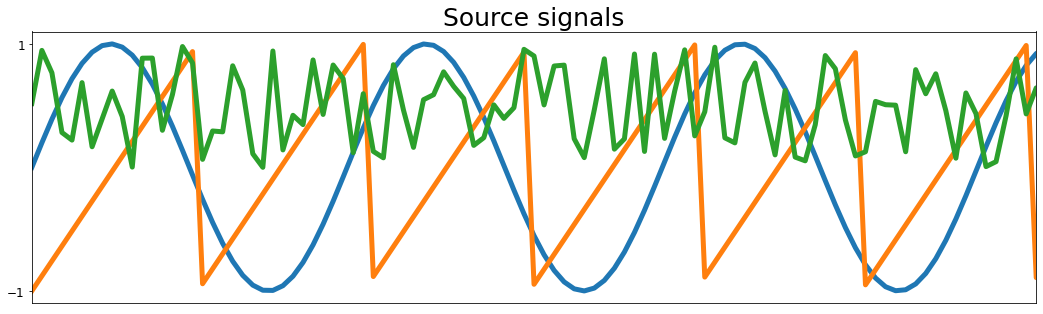

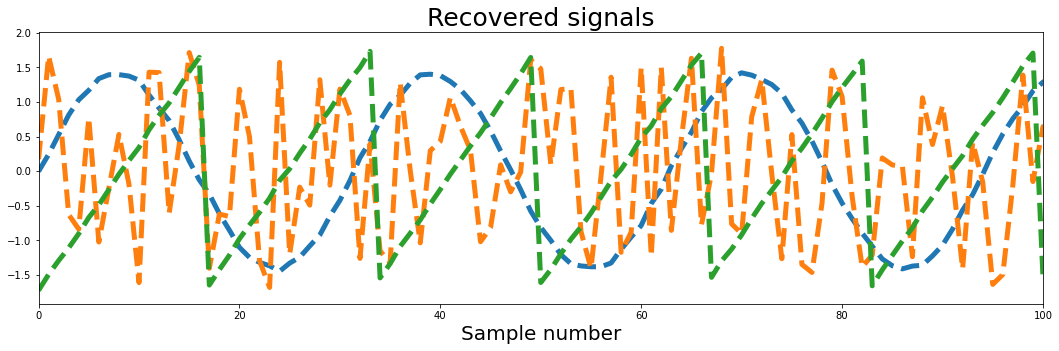

In [7]:
#Fit model FastICA
model_ica = FastICA_model(n_components=3)
S_ = model_ica.fit_transform(X)
#Print the Weight matrix
print('iter ',model_ica.n_iter)
print(model_ica.component_)
print('recovered ', S_.shape)
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S_, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

# Sklearn

iter  4
[[-0.04467784  0.00035877  0.00072316]
 [ 0.00011306  0.05469481  0.00433016]
 [ 0.00053175 -0.00238356  0.10942011]]
recovered  (1000, 3)


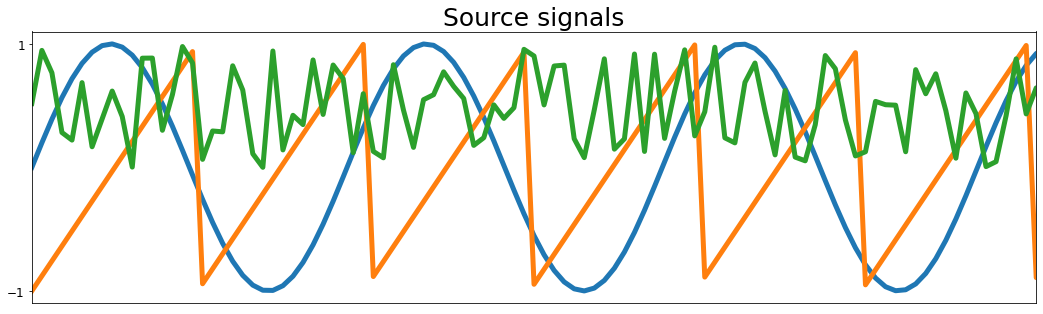

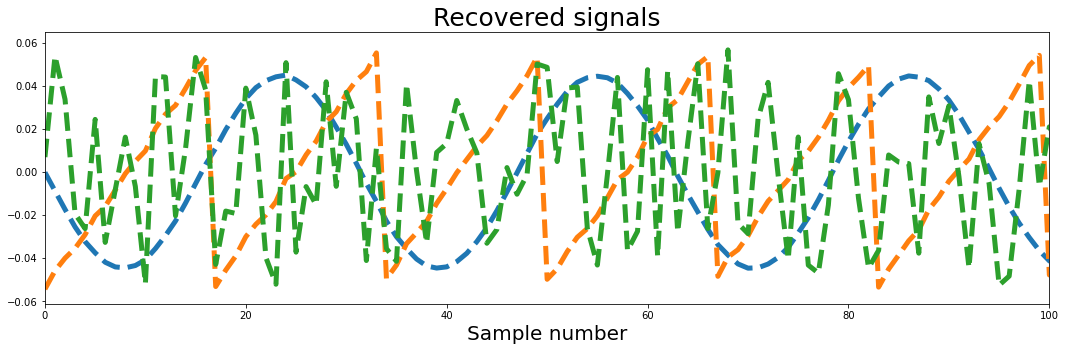

In [8]:
from sklearn.decomposition import FastICA, PCA
# Compute ICA
ica = FastICA(n_components=3)

S_ = ica.fit_transform(S)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix
print('iter ',ica.n_iter_)
print(ica.components_)
print('recovered ', S_.shape)
# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S_, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

In [9]:
print(model_ica.whitening_)
print('sklearn \n',ica.whitening_)

[[ 2.62277611 -0.92332204 -1.1671833 ]
 [-0.92332204  1.94853339 -0.49685095]
 [-1.1671833  -0.49685095  4.33760175]]
sklearn 
 [[-0.04467613 -0.00049315  0.00011667]
 [ 0.00060391 -0.05474492 -0.00014609]
 [ 0.00028916 -0.00028904  0.10950798]]


In [10]:
print(model_ica._unmixing)
print('Sklearn \n',ica._unmixing)

[[ 0.11605282  0.97710819 -0.17830123]
 [-0.18382995  0.19754299  0.96290359]
 [ 0.97608314 -0.07897057  0.20254717]]
Sklearn 
 [[ 0.99986325 -0.0155896   0.00551766]
 [-0.01578934 -0.99914437  0.03822589]
 [-0.00491702  0.03830778  0.99925389]]


In [11]:
print(model_ica.mixing_)
print('Sklearn \n',ica.mixing_)

[[0.35078001 0.14393592 0.58171704]
 [0.70176042 0.24316788 0.29557451]
 [0.13366688 0.28857453 0.23708356]]
Sklearn 
 [[-22.38038579   0.15298668   0.14185752]
 [  0.03758826  18.25153492  -0.72252992]
 [  0.10958113   0.39683921   9.12265942]]


In [12]:
print(model_ica.mean_)
print('Sklearn \n',ica.mean_)

[[0.23607211]
 [0.38157241]
 [0.47544578]]
Sklearn 
 [ 0.00211629 -0.00312163  0.47627117]


# Sklearn

(2000, 3)


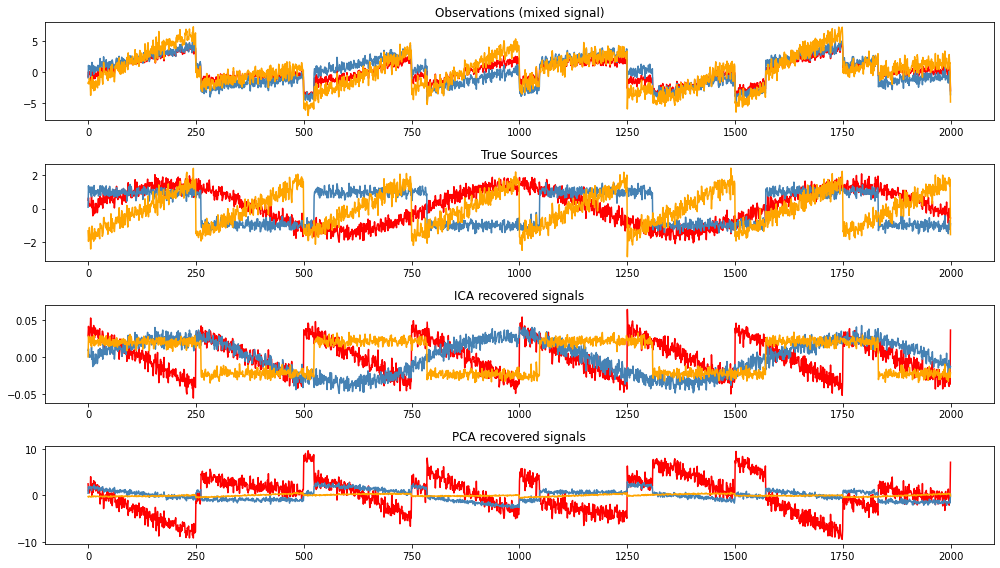

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

from sklearn.decomposition import FastICA, PCA

# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

print(X.shape)
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, np.dot(S_, A_.T) + ica.mean_)

# For comparison, compute PCA
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################
# Plot results

plt.figure(figsize=(14,8))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

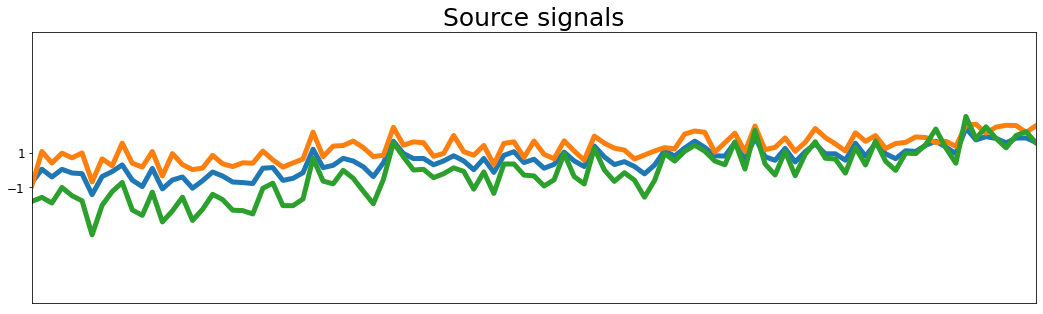

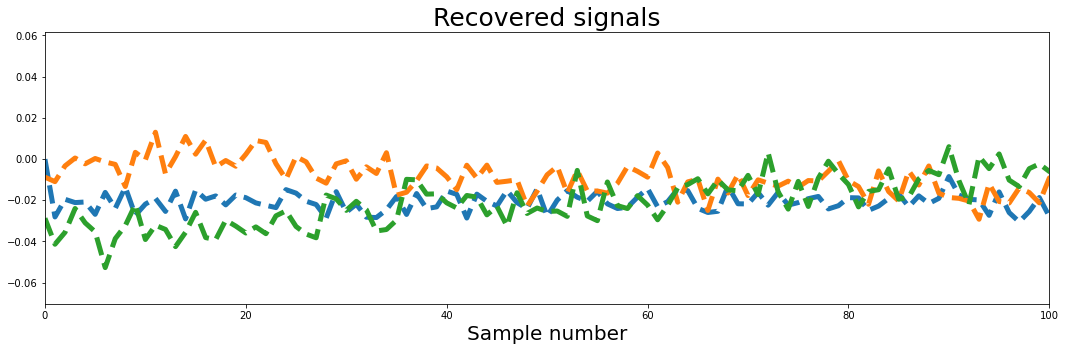

In [14]:
# Compute ICA
ica = FastICA(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# Plot input signals (not mixed)
fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(X, lw=5)
ax.tick_params(labelsize=12)
ax.set_xticks([])
ax.set_yticks([-1, 1])
ax.set_title('Source signals', fontsize=25)
ax.set_xlim(0, 100)

fig, ax = plt.subplots(1, 1, figsize=[18, 5])
ax.plot(S_, '--', label='Recovered signals', lw=5)
ax.set_xlabel('Sample number', fontsize=20)
ax.set_title('Recovered signals', fontsize=25)
ax.set_xlim(0, 100)

plt.show()

# My Model

X_whiten  (3, 2000)
w_init  (3, 3)


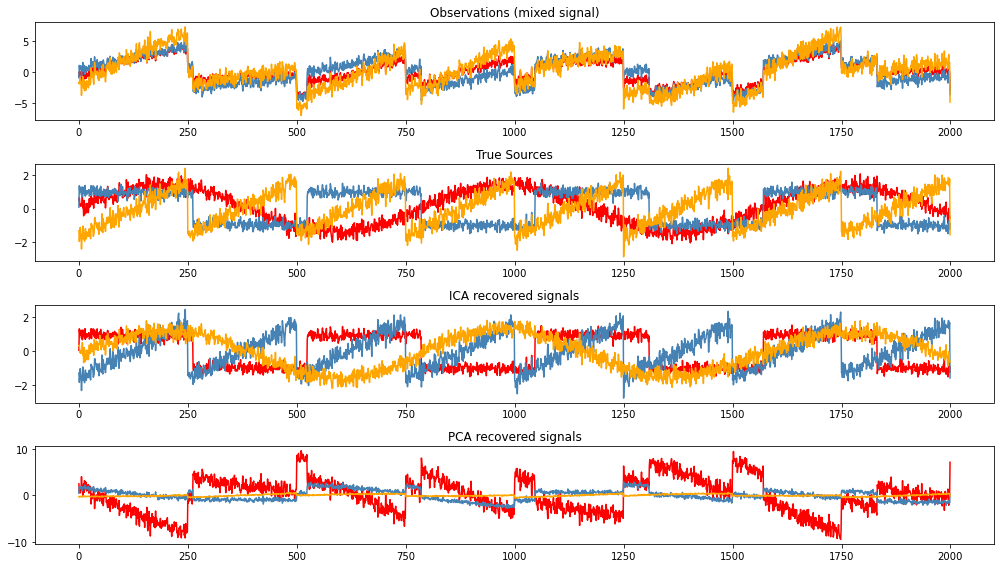

In [15]:
# #############################################################################
# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

s1 = np.sin(2 * time)  # Signal 1 : sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Signal 2 : square signal
s3 = signal.sawtooth(2 * np.pi * time)  # Signal 3: saw tooth signal

S = np.c_[s1, s2, s3]
S += 0.2 * np.random.normal(size=S.shape)  # Add noise

S /= S.std(axis=0)  # Standardize data
# Mix data
A = np.array([[1, 1, 1], [0.5, 2, 1.0], [1.5, 1.0, 2.0]])  # Mixing matrix
X = S.dot(A.T).T  # Generate observations

# Compute ICA
ica = FastICA_model(n_components=3)
S_ = ica.fit_transform(X)  # Reconstruct signals
A_ = ica.mixing_  # Get estimated mixing matrix

# We can `prove` that the ICA model applies by reverting the unmixing.
assert np.allclose(X, S_.dot(A_.T).T + ica.mean_)

# For comparison, compute PCA
X = X.T
pca = PCA(n_components=3)
H = pca.fit_transform(X)  # Reconstruct signals based on orthogonal components

# #############################################################################

# Plot results

plt.figure(figsize=(14,8))

models = [X, S, S_, H]
names = ['Observations (mixed signal)',
         'True Sources',
         'ICA recovered signals',
         'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout()
plt.show()

# Sklearn

In [16]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
# Creating the employee attitude survey data for ICA
rating=[43,63,71,61,81,43,58,71,72,67,64,67,69,68,77,81,74,65,65,50,50,64,53,40,63,66,78,48,85,82]
complaints=[51,64,70,63,78,55,67,75,82,61,53,60,62,83,77,90,85,60,70,58,40,61,66,37,54,77,75,57,85,82]
privileges=[30,51,68,45,56,49,42,50,72,45,53,47,57,83,54,50,64,65,46,68,33,52,52,42,42,66,58,44,71,39]
learning=[39,54,69,47,66,44,56,55,67,47,58,39,42,45,72,72,69,75,57,54,34,62,50,58,48,63,74,45,71,59]
raises=[61,63,76,54,71,54,66,70,71,62,58,59,55,59,79,60,79,55,75,64,43,66,63,50,66,88,80,51,77,64]
critical=[92,73,86,84,83,49,68,66,83,80,67,74,63,77,77,54,79,80,85,78,64,80,80,57,75,76,78,83,74,78]
advance=[45,47,48,35,47,34,35,41,31,41,34,41,25,35,46,36,63,60,46,52,33,41,37,49,33,72,49,38,55,39]

#Joining all the vectors together to form input matrix X
SurveyData=list(zip(rating,complaints,privileges,learning,raises,critical,advance))
import pandas as pd
InpData=pd.DataFrame(data=SurveyData, columns=["rating","complaints","privileges","learning","raises","critical","advance"])
print(InpData.head(10))

#Creating input data numpy array
X=InpData.values
# X = X.T
######################################################################
# Creating ICA object
ICA = FastICA(n_components=2)
IndependentComponentValues=ICA.fit_transform(X)

#Creating the dataframe
print('####### Final Independent Components ######')
ReducedData=pd.DataFrame(data=IndependentComponentValues, columns=['IC1','IC2'])
print(ReducedData.head(10))
print(IndependentComponentValues.shape)

   rating  complaints  privileges  learning  raises  critical  advance
0      43          51          30        39      61        92       45
1      63          64          51        54      63        73       47
2      71          70          68        69      76        86       48
3      61          63          45        47      54        84       35
4      81          78          56        66      71        83       47
5      43          55          49        44      54        49       34
6      58          67          42        56      66        68       35
7      71          75          50        55      70        66       41
8      72          82          72        67      71        83       31
9      67          61          45        47      62        80       41
####### Final Independent Components ######
        IC1       IC2
0  0.322428 -0.222267
1  0.048251 -0.024538
2  0.126337  0.201744
3 -0.034006 -0.128963
4 -0.057919  0.179282
5 -0.081566 -0.273210
6 -0.083588 -0.087798

In [18]:
# Creating the employee attitude survey data for ICA
rating=[43,63,71,61,81,43,58,71,72,67,64,67,69,68,77,81,74,65,65,50,50,64,53,40,63,66,78,48,85,82]
complaints=[51,64,70,63,78,55,67,75,82,61,53,60,62,83,77,90,85,60,70,58,40,61,66,37,54,77,75,57,85,82]
privileges=[30,51,68,45,56,49,42,50,72,45,53,47,57,83,54,50,64,65,46,68,33,52,52,42,42,66,58,44,71,39]
learning=[39,54,69,47,66,44,56,55,67,47,58,39,42,45,72,72,69,75,57,54,34,62,50,58,48,63,74,45,71,59]
raises=[61,63,76,54,71,54,66,70,71,62,58,59,55,59,79,60,79,55,75,64,43,66,63,50,66,88,80,51,77,64]
critical=[92,73,86,84,83,49,68,66,83,80,67,74,63,77,77,54,79,80,85,78,64,80,80,57,75,76,78,83,74,78]
advance=[45,47,48,35,47,34,35,41,31,41,34,41,25,35,46,36,63,60,46,52,33,41,37,49,33,72,49,38,55,39]

#Joining all the vectors together to form input matrix X
SurveyData=list(zip(rating,complaints,privileges,learning,raises,critical,advance))
import pandas as pd
InpData=pd.DataFrame(data=SurveyData, columns=["rating","complaints","privileges","learning","raises","critical","advance"])
print(InpData.head(10))
#Creating input data numpy array
X=InpData.values
X = X.T

   rating  complaints  privileges  learning  raises  critical  advance
0      43          51          30        39      61        92       45
1      63          64          51        54      63        73       47
2      71          70          68        69      76        86       48
3      61          63          45        47      54        84       35
4      81          78          56        66      71        83       47
5      43          55          49        44      54        49       34
6      58          67          42        56      66        68       35
7      71          75          50        55      70        66       41
8      72          82          72        67      71        83       31
9      67          61          45        47      62        80       41


In [19]:
from sklearn.decomposition import FastICA
import matplotlib.pyplot as plt
# Creating the employee attitude survey data for ICA
rating=[43,63,71,61,81,43,58,71,72,67,64,67,69,68,77,81,74,65,65,50,50,64,53,40,63,66,78,48,85,82]
complaints=[51,64,70,63,78,55,67,75,82,61,53,60,62,83,77,90,85,60,70,58,40,61,66,37,54,77,75,57,85,82]
privileges=[30,51,68,45,56,49,42,50,72,45,53,47,57,83,54,50,64,65,46,68,33,52,52,42,42,66,58,44,71,39]
learning=[39,54,69,47,66,44,56,55,67,47,58,39,42,45,72,72,69,75,57,54,34,62,50,58,48,63,74,45,71,59]
raises=[61,63,76,54,71,54,66,70,71,62,58,59,55,59,79,60,79,55,75,64,43,66,63,50,66,88,80,51,77,64]
critical=[92,73,86,84,83,49,68,66,83,80,67,74,63,77,77,54,79,80,85,78,64,80,80,57,75,76,78,83,74,78]
advance=[45,47,48,35,47,34,35,41,31,41,34,41,25,35,46,36,63,60,46,52,33,41,37,49,33,72,49,38,55,39]

#Joining all the vectors together to form input matrix X
SurveyData=list(zip(rating,complaints,privileges,learning,raises,critical,advance))
import pandas as pd
InpData=pd.DataFrame(data=SurveyData, columns=["rating","complaints","privileges","learning","raises","critical","advance"])
print(InpData.head(10))

#Creating input data numpy array
X=InpData.values
# X = X.T
print(X.shape)

######################################################################
# Creating ICA object
ica_m = FastICA_model(n_components=2)
IndependentComponentValues = ica_m.fit_transform(X)[:2,:].T

#Creating the dataframe
print('####### Final Independent Components ######')
ReducedData = pd.DataFrame(data=IndependentComponentValues, columns=['IC1','IC2'])
print(ReducedData.head(10))
print(IndependentComponentValues.shape)

   rating  complaints  privileges  learning  raises  critical  advance
0      43          51          30        39      61        92       45
1      63          64          51        54      63        73       47
2      71          70          68        69      76        86       48
3      61          63          45        47      54        84       35
4      81          78          56        66      71        83       47
5      43          55          49        44      54        49       34
6      58          67          42        56      66        68       35
7      71          75          50        55      70        66       41
8      72          82          72        67      71        83       31
9      67          61          45        47      62        80       41
(30, 7)
X_whiten  (30, 7)
w_init  (2, 2)
####### Final Independent Components ######
        IC1       IC2
0 -0.000003 -0.000002
1  0.000005  0.000004
2  0.236506  1.416514
3  0.216700  1.006179
4  0.570899  1.601731
5 